# Modelling

In this section, we will implement Linear Regression and Random Forest Regression to estimate the hourly taxi demand in NYC.
***

## Import Libraries

In [429]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [398]:
# Starting a Spark session
spk = (
    SparkSession.builder.appName('model')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)


## Split data into training and testing set

In [401]:
# Read the merged and preprocessed dataset
nyc_hourly_demand = spk.read.parquet('../data/curated/combined_data.parquet').toPandas()

# Rename building class C columns as it causes error with the ols function
nyc_hourly_demand.rename({'C':'C_class'}, axis = 1, inplace = True)


In [402]:
# Extract the last month as testing set, the remaining will be our training set
test = nyc_hourly_demand[nyc_hourly_demand['month'] == 4]
train = nyc_hourly_demand[nyc_hourly_demand['month'] != 4]


## Prepare training and testing data for each borough

Based on our preliminary analysis, we saw that daily average demand differed greatly across boroughs, therefore we need to train the model separately on each borough to accurately model the local demand.

In [403]:
# Get all location ids under each borough
borough_id = {}
for borough in nyc_hourly_demand['borough'].unique():
    borough_id[borough] = nyc_hourly_demand[nyc_hourly_demand['borough'] == borough]['pu_location_id'].unique()
    

In [404]:
# Exclude the unnecessary columns
excl_col = ['service_zone','zone','borough', 'geometry']


In [405]:
# Split the data into features and target
X_train = train[[col for col in nyc_hourly_demand.columns if col not in ['count'] + excl_col]]
Y_train = train['count']

X_test = test[[col for col in nyc_hourly_demand.columns if col not in ['count'] + excl_col]]
Y_test = test['count']


In [425]:
# Get XYtrain, XYtest data for each boroughs separately
borough_data = {bor:[] for bor in borough_id.keys()}
for bor in borough_id.keys():
    
    # Find the indices of all records that belong to the borough
    train_idx = X_train[X_train['pu_location_id'].isin(borough_id[bor])].index
    test_idx = X_test[X_test['pu_location_id'].isin(borough_id[bor])].index
    
    # Extract the XYtrain and XYtest based on the indices above
    borough_data[bor].extend([X_train[X_train.index.isin(train_idx)],
                              Y_train[Y_train.index.isin(train_idx)], 
                              X_test[X_test.index.isin(test_idx)], 
                              Y_test[Y_test.index.isin(test_idx)]])
    

In [426]:
len(X_train.columns)

33

## Train and estimate using Linear Regression model on each borough data

Here we will fit a linear model on the training data of each borough and using the model to predict the test data of the borough.

In [409]:
# Get all unique categorical levels for the categorical features
uniq_month = nyc_hourly_demand['month'].unique()
uniq_hour = nyc_hourly_demand['pickup_hour'].unique()
uniq_dayweek = nyc_hourly_demand['day_of_week'].unique()

# Train LinearRegressor on each borough data
lr_equation_1 = ('count ~ C(pu_location_id) + C(month, levels=uniq_month) +'
                 '+ C(day_of_week, levels=uniq_dayweek) +'
                 'C(pickup_hour, levels=uniq_hour) + TMP + DEW + SLP + A + B + C_class + V + ' +
                'S + D + K + O + M + G + W + E + N + P + F + Z + U + Q + H + Y + I + R + J + T + total_lot')

lr_equation_2 = ('count ~ C(pu_location_id) + C(month, levels=uniq_month) +' +
               'C(day_of_week) + C(pickup_hour, levels=uniq_hour) + TMP + DEW + SLP + D + H + total_lot')


borough_lr_model = {bor: ols(lr_equation_1, 
                             data=pd.concat([borough_data[bor][0], borough_data[bor][1]], axis=1),
                             missing='drop').fit() \
                 for bor in borough_id.keys()}


In [410]:
# Obtain Linear Regression predictions
borough_lr_pred = {}
for bor in borough_id.keys():
    borough_lr_pred[bor] = borough_lr_model[bor].predict(borough_data[bor][2])
    

In [415]:
# RMSE of the Linear Regression predictions
print("RMSE of the Linear Regression model:")
for bor in borough_id.keys():
    print(f"  {bor}: {np.sqrt(mean_squared_error(borough_data[bor][3], borough_lr_pred[bor]))}")
    

RMSE of the Linear Regression model:
  Manhattan: 46.26487929860821
  Queens: 34.246736796769184
  Brooklyn: 1.7968463355613176
  Bronx: 0.5849560426840441
  Staten Island: 1.485636510419368
  EWR: 15.477113911654733


In [430]:
# MAE of the Linear Regression predictions
print("MAE of the Linear Regression model:")
for bor in borough_id.keys():
    print(f"  {bor}: {(mean_absolute_error(borough_data[bor][3], borough_lr_pred[bor]))}")
    

MAE of the Linear Regression model:
  Manhattan: 32.86158085253451
  Queens: 17.985263057167714
  Brooklyn: 1.0248753436492302
  Bronx: 0.32517804862747496
  Staten Island: 1.1664094914638752
  EWR: 12.116204751313312


## Train and estimate using Random Forest Regression model on each borough data

Here we will fit the Random Forest Regressor on the training data of each borough and using the model to predict the test data of the borough. However, before we train the model, we need to tune the hyperparameter to ensure optimum performance of the model.

In [416]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    '''
    Given a set of hyperparameters, return the model that produces the most optimal result
    based on the scoring function.
    '''
    if score_func:
        gs = GridSearchCV(clf, 
                          param_grid=parameters, 
                          cv=n_folds, 
                          n_jobs=n_jobs, 
                          scoring=score_func, 
                          verbose=verbose)
    else:
        # Use default scoring function
        gs = GridSearchCV(clf, 
                          param_grid=parameters, 
                          n_jobs=n_jobs, 
                          cv=n_folds, 
                          verbose=verbose)
    
    gs.fit(X, y)
    
    print("BEST", gs.best_params_, gs.best_score_)
    print("Best score: ", gs.best_score_)
    
    best = gs.best_estimator_
    
    return best


Due to the long computation time, we decided to tune the hyperparameter using the entire training data instead of spliting into different boroughs. For 5 boroughs, we need to run $5^2*3^3=675$ iterations (including the 5-fold cv) to find the optimal configurations compared to the $135$ iterations if we were to run the GridSearch on the whole training data set. We will therefore use this result to approximate the optimal configurations for each of the model.

In [418]:
# Hyperparameter tuning for the Random Forest Regression model on the training data
# parameters = {"n_estimators": [10,50,100],
#               "max_features": ["auto",'sqrt','log2'],
#               "max_depth": [10,50,70]}

# best = cv_optimize(RFR, 
#                    parameters, 
#                    X_train, 
#                    Y_train, 
#                    n_folds=5, 
#                    score_func='neg_root_mean_squared_error', 
#                    verbose=3)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-73.807 total time=  14.3s
[CV 2/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-80.922 total time=  15.4s
[CV 3/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-58.882 total time=  16.9s
[CV 4/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-41.526 total time=  15.3s
[CV 5/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-43.551 total time=  13.3s
[CV 1/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-72.642 total time= 1.0min
[CV 2/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-80.073 total time= 1.1min
[CV 3/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-59.756 total time= 1.1min
[CV 4/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-41.590 total time= 1.1min
[CV 5/5] END max_depth=10, max_features=auto, n_estimators=50;, s

[CV 5/5] END max_depth=50, max_features=log2, n_estimators=50;, score=-33.114 total time=  27.9s
[CV 1/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-71.090 total time=  50.4s
[CV 2/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-60.643 total time=  50.3s
[CV 3/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-37.909 total time=  52.8s
[CV 4/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-34.366 total time=  50.8s
[CV 5/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-30.565 total time=  52.8s
[CV 1/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-71.406 total time=  22.3s
[CV 2/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-78.843 total time=  23.9s
[CV 3/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-60.051 total time=  24.0s
[CV 4/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-38.753 total time=  23.5s
[CV 5/5] END max_depth=70

Based on our 135 iterations of GridSearchCV, the most optimal hyperparameters for the model is:
- max_depth: 70
- max_features: sqrt
- n_estimators: 100

In [427]:
# Train and predict RandomForestRegressor on each borough test data
borough_rfr_model = {bor: RandomForestRegressor(max_depth=70, max_features='sqrt', n_estimators=100) \
                 for bor in borough_id.keys()}
borough_rfr_pred = {}

for bor in borough_id.keys():
    borough_rfr_model[bor].fit(borough_data[bor][0], borough_data[bor][1])
    borough_rfr_pred[bor] = borough_rfr_model[bor].predict(borough_data[bor][2])
    

In [428]:
# RMSE of the RandomForestRegressor predictions
print("RMSE of the Random Forest Regression model:")
for bor in borough_id.keys():
    print(f"{bor}: {np.sqrt(mean_squared_error(borough_data[bor][3], borough_rfr_pred[bor]))}")
    

RMSE of the Random Forest Regression model:
Manhattan: 20.457711374704736
Queens: 16.090666965050005
Brooklyn: 1.5885964697108472
Bronx: 0.5823042709469015
Staten Island: 1.4571983349024231
EWR: 16.694123520672083


In [431]:
# MAE of the RandomForestRegressor predictions
print("MAE of the Random Forest Regression model:")
for bor in borough_id.keys():
    print(f"{bor}: {(mean_absolute_error(borough_data[bor][3], borough_rfr_pred[bor]))}")

MAE of the Random Forest Regression model:
Manhattan: 12.097745072683974
Queens: 5.481133801515432
Brooklyn: 0.8595189163942083
Bronx: 0.3214016364283173
Staten Island: 1.1044847890088323
EWR: 13.108185185185185


In [238]:
rand_day = X_test[(X_test['pu_location_id'] == 261) &
                  (X_test['month'] == 3) &
                  (X_test['day_of_month'] == 10)]


In [239]:
rand_day

,pu_location_id,year,month,day_of_month,day_of_week,is_weekday,pickup_hour,TMP,DEW,SLP,...,Z,U,Q,H,Y,I,R,J,T,total_lot
145295,261,2022,3,10,5,True,20,8.9,-3.3,1019.9,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
145534,261,2022,3,10,5,True,18,9.4,-4.4,1020.3,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
146063,261,2022,3,10,5,True,3,2.2,-0.6,1017.2,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
146183,261,2022,3,10,5,True,19,9.4,-3.9,1020.1,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
146225,261,2022,3,10,5,True,13,2.8,0.0,1022.8,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
146435,261,2022,3,10,5,True,23,7.2,-1.7,1020.2,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
146823,261,2022,3,10,5,True,15,5.0,0.6,1023.1,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
146929,261,2022,3,10,5,True,1,2.2,0.0,1015.6,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
147439,261,2022,3,10,5,True,12,1.7,0.0,1023.0,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0
147685,261,2022,3,10,5,True,0,1.7,0.0,1015.2,...,0.0,1.0,5.0,8.0,1.0,0.0,12.0,0.0,0.0,85.0


In [242]:
y_test_idx

Int64Index([  6686,   6687,   6688,   6689,   6690,   6691,   6708,   6709,
              6710,   6711,
            ...
            421373, 421374, 421376, 421390, 421391, 421392, 421400, 421401,
            421402, 421404],
           dtype='int64', length=83588)

In [244]:
y_pred

pickup_hour
8      71.34
17    200.02
23    143.26
14    177.06
17    189.70
       ...  
14      3.48
13      3.48
16      5.06
17      2.08
2       1.24
Length: 83588, dtype: float64

In [246]:
y_test_idx = borough_data['Manhattan'][3].index
y_pred = pd.Series(borough_pred['Manhattan'], index=y_test_idx)
manhat_test = pd.concat([borough_data['Manhattan'][2], borough_data['Manhattan'][3], y_pred], axis=1)

In [254]:
manhat_test.rename({0:'pred_count'}, inplace=True, axis=1)

<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

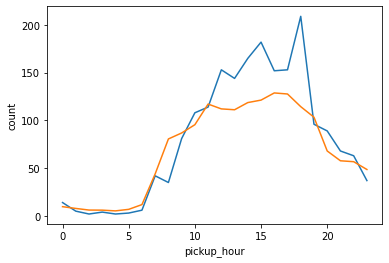

In [276]:
rand_day = manhat_test[(manhat_test['pu_location_id'] == 43) &
                      (manhat_test['month'] == 3) &
                      (manhat_test['day_of_month'] == 18)]
sns.lineplot(x='pickup_hour', y='count', data=rand_day)
sns.lineplot(x='pickup_hour', y='pred_count', data=rand_day)

In [226]:
replace_index = nyc_hourly_demand.loc[borough_data['Manhattan'][3].index, 'pickup_hour']

In [227]:
replace_index

6686       8
6687      17
6688      23
6689      14
6690      17
          ..
421392    14
421400    13
421401    16
421402    17
421404     2
Name: pickup_hour, Length: 83588, dtype: int64

In [232]:
y_pred

pickup_hour
8      71.34
17    200.02
23    143.26
14    177.06
17    189.70
       ...  
14      3.48
13      3.48
16      5.06
17      2.08
2       1.24
Length: 83588, dtype: float64

ValueError: x and y must be the same size

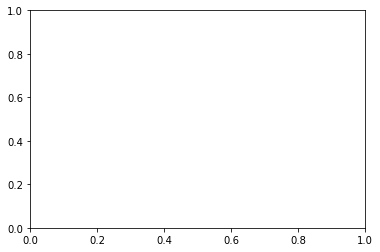

In [262]:
plt.scatter(x=set(y_pred.index), y=y_pred)

In [220]:
borough_data['Manhattan'][3][rand_day]

145295    38
145534    18
146063     1
146183    31
146225    32
146435    19
146823    30
146929     2
147439    32
147685     4
147923    22
148185    16
148324    24
148348    23
148865    24
149224    31
149253    34
149434     2
149593     9
149594    29
149618    16
149754     1
Name: count, dtype: int64

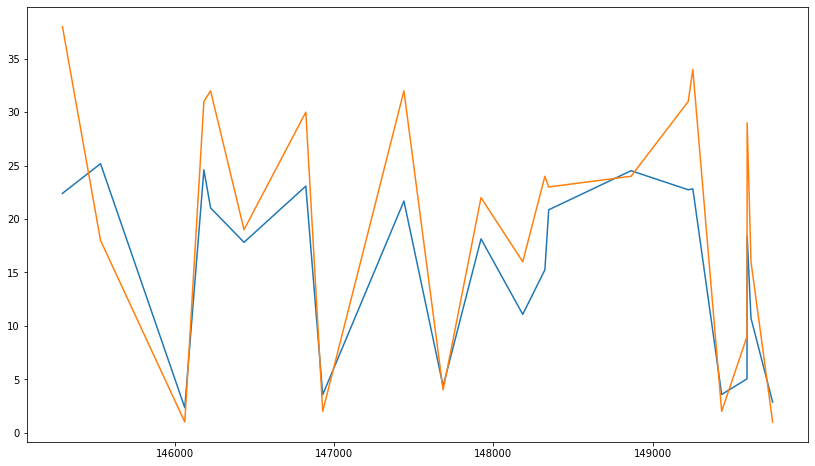

In [218]:
fig, ax = plt.subplots(1, figsize=(14,8))
plt.plot(y_pred[rand_day])
plt.plot(borough_data['Manhattan'][3][rand_day])

In [194]:
y_pred = RFR.predict(X_test)

In [ ]:
RFR.feature_importances_

<BarContainer object of 35 artists>

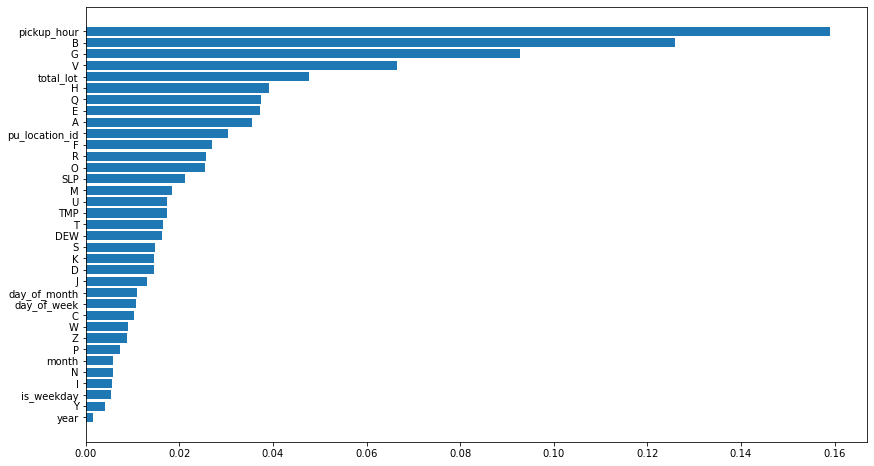

In [137]:
fig, ax = plt.subplots(1, figsize=(14,8))
sorted_idx = RFR.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], RFR.feature_importances_[sorted_idx])


In [142]:
np.sqrt(mean_squared_error(Y_test, y_pred))

0.20752312446650625

In [159]:
Y_test[manh_idx]

6686      1.995635
6687      2.406540
6688      2.089905
6689      2.235528
6690      2.342423
            ...   
421392    0.000000
421400    0.000000
421401    0.000000
421402    0.000000
421404    0.000000
Name: count, Length: 83588, dtype: float64

In [160]:
np.sqrt(mean_squared_error(Y_test[manh_idx], y_pred_manh))

0.2101746661439497

In [140]:
Y_test

0         0.000000
1         2.238046
2         1.973128
3         1.361728
4         2.103804
            ...   
421787    0.000000
421789    0.000000
421790    0.000000
421795    0.000000
421799    0.000000
Name: count, Length: 126280, dtype: float64

In [141]:
list(np.round(np.power(10,np.column_stack((y_pred,Y_test))) - 1,decimals=0).astype(int))

[array([4, 0]),
 array([134, 172]),
 array([67, 93]),
 array([ 2, 22]),
 array([ 89, 126]),
 array([  2, 120]),
 array([130,  81]),
 array([156, 182]),
 array([85, 87]),
 array([ 75, 114]),
 array([ 2, 12]),
 array([102, 220]),
 array([152, 172]),
 array([41, 45]),
 array([166, 221]),
 array([131, 186]),
 array([143, 221]),
 array([114, 154]),
 array([124, 176]),
 array([115, 194]),
 array([42, 99]),
 array([ 72, 115]),
 array([151, 220]),
 array([107, 219]),
 array([ 96, 227]),
 array([34, 45]),
 array([ 3, 13]),
 array([165, 241]),
 array([138, 161]),
 array([140, 225]),
 array([109, 141]),
 array([152, 194]),
 array([ 96, 149]),
 array([6, 3]),
 array([104, 252]),
 array([2, 8]),
 array([ 85, 193]),
 array([3, 0]),
 array([1, 0]),
 array([122, 188]),
 array([3, 0]),
 array([ 81, 111]),
 array([141, 212]),
 array([154, 181]),
 array([92, 44]),
 array([158, 182]),
 array([2, 2]),
 array([124, 229]),
 array([116, 210]),
 array([118, 148]),
 array([3, 2]),
 array([100, 203]),
 array([10

In [43]:
RFR.train()

array([-1.88772823, -1.63603507, -1.19160235])

In [39]:
RFR

RandomForestRegressor(max_features=14, n_estimators=300)

In [48]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_, gs.scorer_)
    print("Best score: ", gs.best_score_)
    best = gs.best_estimator_
    return best

In [54]:
parameters = {"n_estimators": [10,50,100],
              "max_features": ["auto",'sqrt','log2'], # ["auto","sqrt","log2"]
              "max_depth": [10,50]}
best = cv_optimize(RFR, parameters, X, Y, n_folds=5, score_func='neg_mean_absolute_error', verbose=3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-1.416 total time=   1.2s
[CV 2/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-1.558 total time=   1.1s
[CV 3/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-1.416 total time=   1.1s
[CV 4/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-0.810 total time=   1.1s
[CV 5/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-1.146 total time=   1.1s
[CV 1/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-1.428 total time=   5.1s
[CV 2/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-1.580 total time=   5.0s
[CV 3/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-1.405 total time=   6.4s
[CV 4/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-0.825 total time=   6.6s
[CV 5/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-1.1

[CV 1/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-1.222 total time=   5.1s
[CV 2/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-1.236 total time=   4.6s
[CV 3/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-1.192 total time=   4.4s
[CV 4/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-0.803 total time=   4.2s
[CV 5/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-1.110 total time=   4.3s
[CV 1/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-1.425 total time=   1.8s
[CV 2/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-1.505 total time=   1.7s
[CV 3/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-1.477 total time=   1.8s
[CV 4/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-0.871 total time=   1.8s
[CV 5/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-1.180 total time=   1.7s
[CV 1/5] END max_depth=70, max_feat

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [53]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we